# 	Interactive exploration with widgets and dashboards

Here, we will use a motivating example that looks at CO$_2$ data to demonstrate linear regression to introduce:
- [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html) and 
- [Voilà dashboards](https://voila.readthedocs.io/en/latest/?badge=latest)

The example we follow is adapted from the [Intro-Jupyter tutorial from ICESat-2Hackweek](https://github.com/ICESAT-2HackWeek/intro-jupyter), which has contributions from: [Shane Grigsby (@espg)](https://github.com/espg), [Lindsey Heagy (@lheagy)](https://github.com/lheagy), [Yara Mohajerani (@yaramohajerani)](https://github.com/yaramohajerani), and [Fernando Pérez (@fperez)](https://github.com/fperez). 

## 1. 👋  Hello

and a bit about me... 

Hi, I'm Lindsey 
- I am currently a Postdoc at UC Berkeley in the Department of Statistics
- and will be joining UBC-EOAS as an Asst. Prof in July 2021 
- PhD in computational geophysics (modelling and inversions)
- Throughout, I have been involved in development of open source software in Python & open educational resources


## 2. Motivating example: CO$_2$ at Mauna Loa

**Question:** Based on historical CO$_2$ data, can we estimate what CO$_2$ concentrations will be in the future? 

Scripps institute of Oceanography has a research station at Mauna Loa in Hawaii where they have been measuring atmospheric CO$_2$ since 1958. The data we will focus on are the seasonally adjusted data. 

<img src="https://scrippsco2.ucsd.edu/assets/images/mlo_station_map.png" align="center">

**Data Source**

C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and  H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and  oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps  Institution of Oceanography, San Diego, 88 pages, 2001. https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html   

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

### 2.1 Load, clean and plot the data

We first do some light cleaning to remove rows with missing data, and then plot up our data set. We will work with the seasonally adjusted data. For a description of the data types we can consider, please see the [description from Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). 

In [3]:
co2_data_source = "./data/monthly_in_situ_co2_mlo.csv"
co2_data_full = pd.read_csv(
    co2_data_source, 
    skiprows=np.arange(0, 56), 
    na_values="-99.99"
)

co2_data_full.columns = [
    "year", "month", "date (int)", "date", "co2", "seasonally adjusted",
    "fit", "seasonally adjusted fit", "co2 filled", "seasonally adjusted filled" 
]

co2_data = co2_data_full.dropna()

In [4]:
def get_data_between(data=co2_data, date_range=None, data_type="seasonally adjusted"):
    """
    A function to fetch data between year_min and year_max  
    """
    if date_range is None:
        date_range = data["date"].min(), data["date"].max()

    # find the data between the minimimum and maximum years
    indices = (data["date"] >= date_range[0]) & (data["date"] <= date_range[1]) 
    return data["date"][indices], data[data_type][indices]

In [5]:
def plot_co2_data(data=co2_data, date_range=None, data_type="seasonally adjusted", ax=None):
    """
    A function that we can use to plot data between year_min and year_max
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
    dates, data_between = get_data_between(data, date_range, data_type)
        
    # plot data
    ax.plot(dates, data_between, '.',  ms=8)
    ax.grid()
    ax.set_xlabel(f"Year")
    ax.set_ylabel(f"CO$_2$ [ppm]")

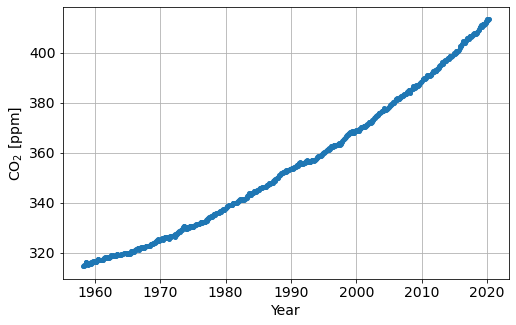

In [6]:
plot_co2_data(co2_data) # ,[1958, 1963])

### 2.2 Making predictions: Focus on the first 5 years

**Question:** If the trend between 1958 and 1963 continues, what would we expect the CO$_2$ concentration to be in January, 2030?  

#### Part 1: The "eyeball" norm - with widgets!

- using the widgets below, estimate a slope and intercept of a line that fits the data
- the `slope` indicates the rate of CO$_2$ accumulation per year
- the `intercept` is the estimated concentration of CO$_2$ at the first point we consider

In [7]:
import ipywidgets as widgets

In [8]:
def add_line(dates, slope, intercept, ax=None, label=None):
    """
    A function to add a line to a plot
    """    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    y = slope * (dates - dates.min()) + intercept
    ax.plot(dates, y, label=label)

In [9]:
def plot_fit_co2_data(slope, intercept, year_min=1958, year_max=2020, data_type="seasonally adjusted"):
    """
    This function creates an interactive widget where we can fit a curve to data
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plot_co2_data(co2_data, [year_min, year_max], data_type, ax=ax)
    add_line(np.r_[year_min, year_max], slope, intercept, ax=ax)
    return ax

In [10]:
year_min = 1958
year_max = 1963

w_co2 = widgets.interactive(
    plot_fit_co2_data, 
    slope=widgets.FloatSlider(
        min=0, max=5, step=0.1, value=2
    ),
    intercept=widgets.FloatSlider(
        min=co2_data["seasonally adjusted"].min()-5, 
        max=co2_data["seasonally adjusted"].min()+5, 
        step=0.25
    ),
    year_min=widgets.fixed(year_min),
    year_max=widgets.fixed(year_max),
    data_type=widgets.fixed("seasonally adjusted")
)
w_co2

interactive(children=(FloatSlider(value=2.0, description='slope', max=5.0), FloatSlider(value=309.44, descript…

#### Make a prediction 

Based on your estimated slope and intercept values: what do you estimate the CO$_2$ concentration would be in 2030? 

In [11]:
def predict_co2(slope, intercept, initial_date, prediction_date):
    """
    based on an estimated slope, and intercept use a linear 
    model to predict CO2 concentration
    """
    return slope * (prediction_date-initial_date) + intercept

In [12]:
def print_prediction(year_predict):
    predicted_co2 = predict_co2(
        w_co2.kwargs["slope"], w_co2.kwargs["intercept"], year_min, year_predict
    )
    print(
        f"Predicted CO2 in {year_predict}: "
        f"{predicted_co2:1.2f} ppm"
    )
    return predicted_co2

In [13]:
w_predict = widgets.interactive(
    print_prediction,
    year_predict = widgets.IntSlider(min=1958, max=2100, value=2020)
)
w_predict

interactive(children=(IntSlider(value=2020, description='year_predict', max=2100, min=1958), Output()), _dom_c…

Text(2019, 433.44, '433.44 ppm')

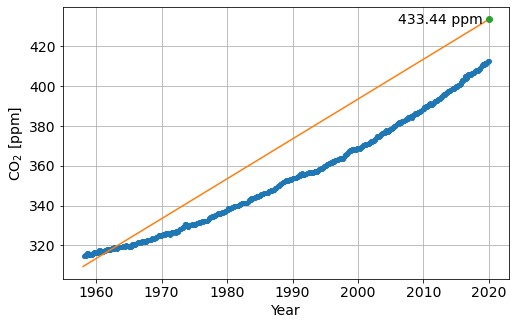

In [14]:
ax = plot_fit_co2_data(
    slope=w_co2.kwargs['slope'], intercept=w_co2.kwargs['intercept'],
) 

year_predict = w_predict.kwargs["year_predict"]
val_predict = w_predict.result

ax.plot(year_predict, val_predict, 'o')
ax.text(year_predict - 1, val_predict, f"{val_predict:1.2f} ppm", ha="right", va="center")

## 3. More on Widgets: Using Interact 

The `interact` function `ipywidgets.interact` is the quickest way to create user interface controls in code. It is the easiest way to get up and running!


### 3.1 Basic `interact`

At the most basic level, `interact` autogenerates controls for function arguments, and then calls the function with those arguments when you manipulate the controls interactively. To use `interact`, you need to define a function that you want to explore. 

In [15]:
def f(x):
    return 3*x

When you pass this function as the first argument to `interact` along with an integer keyword argument (`x=10`), a slider is generated and bound to the function parameter.

In [16]:
widgets.interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

If you pass `True` or `False`, `interact` will generate a checkbox:

In [17]:
widgets.interact(f, x=True);

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

If you pass a string, `interact` will generate a `Text` field.

In [18]:
widgets.interact(f, x='Hello!');

interactive(children=(Text(value='Hello!', description='x'), Output()), _dom_classes=('widget-interact',))

`interact` can also be used as a decorator. This allows you to define a function and interact with it in a single shot. As this example shows, `interact` also works with functions that have multiple arguments.

In [19]:
@widgets.interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, …

#### Fixing arguments with `fixed`

There are times when you may want to explore a function using `interact`, but fix one or more of its arguments to specific values. This can be accomplished by wrapping values with the `fixed` function.

In [20]:
def h(p, q):
    return (p, q)

In [21]:
widgets.interact(h, p=5, q=widgets.fixed(20));

interactive(children=(IntSlider(value=5, description='p', max=15, min=-5), Output()), _dom_classes=('widget-in…

#### Widget abbreviations

When you pass an integer-valued keyword argument of `10` (`x=10`) to `interact`, it generates an integer-valued slider control with a range of `[-10,+3*10]`. In this case, `10` is an *abbreviation* for an actual slider widget:

```python
IntSlider(min=-10,max=30,step=1,value=10)
```

In fact, we can get the same result if we pass this `IntSlider` as the keyword argument for `x`:

In [22]:
widgets.interact(
    f, x=widgets.IntSlider(min=-10, max=30, step=1, value=10)
);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

This examples clarifies how `interact` proceses its keyword arguments:

1. If the keyword argument is a `Widget` instance with a `value` attribute, that widget is used. Any widget with a `value` attribute can be used, even custom ones.
2. Otherwise, the value is treated as a *widget abbreviation* that is converted to a widget before it is used.

The following table gives an overview of different widget abbreviations:

<table class="table table-condensed table-bordered">
  <tr><td><strong>Keyword argument</strong></td><td><strong>Widget</strong></td></tr>  
  <tr><td>`True` or `False`</td><td>Checkbox</td></tr>  
  <tr><td>`'Hi there'`</td><td>Text</td></tr>
  <tr><td>`value` or `(min,max)` or `(min,max,step)` if integers are passed</td><td>IntSlider</td></tr>
  <tr><td>`value` or `(min,max)` or `(min,max,step)` if floats are passed</td><td>FloatSlider</td></tr>
  <tr><td>`['orange','apple']` or `[('one', 1), ('two', 2)]`</td><td>Dropdown</td></tr>
</table>
Note that a dropdown is used if a list or a list of tuples is given (signifying discrete choices), and a slider is used if a tuple is given (signifying a range).

### 3.2 `interactive`

`interactive` is useful when you want to reuse the widgets that are produced or access the data that is bound to the UI controls.

Note that unlike `interact`, the return value of the function will not be displayed automatically, but you can display a value inside the function with `IPython.display.display`.

In [23]:
from IPython.display import display

def f(a, b):
    display(a + b)
    return a+b

Unlike `interact`, `interactive` returns a `Widget` instance rather than immediately displaying the widget.

In [24]:
w = widgets.interactive(f, a=10, b=20)
w

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

The widget is an `interactive`, a subclass of `VBox`, which is a container for other widgets.

In [25]:
type(w)

ipywidgets.widgets.interaction.interactive

The children of the `interactive` are two integer-valued sliders and an output widget, produced by the widget abbreviations above.

In [26]:
w.children

(IntSlider(value=10, description='a', max=30, min=-10),
 IntSlider(value=20, description='b', max=60, min=-20),
 Output())

To actually display the widgets, you can use IPython's `display` function.

In [27]:
display(w)

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

At this point, the UI controls work just like they would if `interact` had been used. You can manipulate them interactively and the function will be called. However, the widget instance returned by `interactive` also gives you access to the current keyword arguments and return value of the underlying Python function. 

Here are the current keyword arguments. If you rerun this cell after manipulating the sliders, the values will have changed.

In [28]:
w.kwargs

{'a': 10, 'b': 20}

Here is the current return value of the function.

In [29]:
w.result

30

## 4. Voilà Dashboards

> Voilà turns Jupyter notebooks into standalone web applications.
> 
> Unlike the usual HTML-converted notebooks, each user connecting to the Voilà tornado application gets a dedicated Jupyter kernel which can execute the callbacks to changes in Jupyter interactive widgets.

- The [intro blog](https://blog.jupyter.org/and-voil%C3%A0-f6a2c08a4a93) provides an overview and resources for getting up and running with Voilà
- The [Voilà gallery](https://voila-gallery.org/) has a collection of examples built with Voilà and Jupyter widgets. 


#### running voila ([docs](https://voila.readthedocs.io/en/stable/using.html#using-voila)):
- you can run Voilà as a standalone server 
  
  ```
  voila notebook.ipynb
  ```
  
  
- or as a server extention by changing the url to `<url-of-my-server>/voila` (e.g. if you launched `jupyter lab` locally, and it was running at `http://localhost:8888/lab`, then then Voilà would be accessed at `http://localhost:8888/voila`.


- there is also a JupyterLab extention for previewing your dashboard
   
   ```
   jupyter labextension install @jupyter-voila/jupyterlab-preview
   ```

- by default, Voilà will strip out the source code from view. It can be displayed if the option `strip_sources` is set to False